In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import math, random
from tqdm import tqdm
from collections import deque
# Monte Carlo EPC via component sampling
def component_sampling_epc_mc(G: nx.Graph,
                              S: set,
                              num_samples: int = 10_000,
                              epsilon=None,
                              delta=None,
                              use_tqdm: bool=False) -> float:
    """
    Approximate expected pairwise connectivity by sampling BFS from random seeds.
    G: current graph
    S: set of deleted nodes (ignored since G has only remaining nodes)
    """
    V_remaining = set(G.nodes()) - S
    n_rem = len(V_remaining)
    if n_rem < 2:
        return 0.0
    if num_samples is None:
        assert epsilon is not None and delta is not None
        P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
        coeff = 4 * (math.e - 2) * math.log(2 / delta)
        num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                                (epsilon ** 2 * P_E))
    C2 = 0
    iterator = tqdm(range(num_samples), desc='Component sampling', total=num_samples) if use_tqdm else range(num_samples)
    for _ in iterator:
        u = random.choice(tuple(V_remaining))
        visited = {u}
        queue = [u]
        while queue:
            v = queue.pop()
            for w in G.neighbors(v):
                if w in V_remaining and random.random() < G.edges[v, w]['p']:
                    if w not in visited:
                        visited.add(w)
                        queue.append(w)
        C2 += (len(visited) - 1)
    return (n_rem * C2) / (2 * num_samples)

# Wrapper so environment can call EPC uniformly
def expected_pairwise_connectivity(G: nx.Graph) -> float:
    return component_sampling_epc_mc(G, set(), num_samples=10000, use_tqdm=False)

class CNDPEnv:
    def __init__(self, G_original: nx.Graph, k: int):
        self.G0 = G_original.copy()
        self.node_list = list(self.G0.nodes())
        self.idx_of = {node: i for i, node in enumerate(self.node_list)}
        self.N = len(self.node_list)
        self.k = k
        self.reset()

    def reset(self):
        self.G = self.G0.copy()
        self.available = set(self.node_list)
        self.steps = 0
        self.epc_prev = expected_pairwise_connectivity(self.G)
        return self._get_obs()

    def _get_obs(self) -> dict:
        A = torch.zeros((self.N, self.N), dtype=torch.float32)
        for u, v in self.G.edges():
            i, j = self.idx_of[u], self.idx_of[v]
            A[i, j] = 1.0
            A[j, i] = 1.0
        I = torch.eye(self.N, dtype=torch.float32)
        A_hat = A + I
        deg = A_hat.sum(1)
        D_inv_sqrt = torch.diag(torch.pow(deg + 1e-7, -0.5))
        adj_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt
        x = torch.ones(self.N, 1, dtype=torch.float32)
        mask = torch.tensor([node in self.available for node in self.node_list], dtype=torch.bool)
        return {"x": x, "adj": adj_norm, "mask": mask}

    def step(self, action: int):
        node = self.node_list[action]
        if node not in self.available:
            raise ValueError(f"Invalid action {action}: node already removed")
        self.G.remove_node(node)
        self.available.remove(node)
        self.steps += 1
        epc_curr = expected_pairwise_connectivity(self.G)
        reward = -epc_curr
        self.epc_prev = epc_curr
        done = (self.steps >= self.k) or (len(self.available) == 0)
        obs = self._get_obs()
        info = {"epc": epc_curr}
        return obs, reward, done, info

class GCNEncoder(nn.Module):
    def __init__(self, in_feats: int, hidden_feats: int, out_feats: int):
        super().__init__()
        self.conv1 = nn.Linear(in_feats, hidden_feats)
        self.conv2 = nn.Linear(hidden_feats, out_feats)

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.conv1(adj @ x))
        h = self.conv2(adj @ h)
        return h


def sanity_check(num_episodes: int = 10):
    # Generate ER graph
    N = 100; p_edge = 0.0443
    G = nx.erdos_renyi_graph(N, p_edge)
    
    for u, v in G.edges():
        G[u][v]['p'] = 1.0

    k = 10
    env = CNDPEnv(G, k)
    encoder = GCNEncoder(in_feats=1, hidden_feats=16, out_feats=8)

    for ep in range(num_episodes):
        obs = env.reset()
        total_reward = 0.0
        epc_trace = []
        done = False
        while not done:
            x, adj, mask = obs['x'], obs['adj'], obs['mask']
            _ = encoder(x, adj)  # forward only
            avail = torch.nonzero(mask).squeeze().tolist()
            avail = [avail] if isinstance(avail, int) else avail
            action = int(np.random.choice(avail))
            obs, reward, done, info = env.step(action)
            total_reward += reward
            epc_trace.append(info['epc'])

        avg_epc = sum(epc_trace) / len(epc_trace)
        print(f"Episode {ep+1}/{num_episodes}")
        print(f"  EPC trace:     {['{:.2f}'.format(e) for e in epc_trace]}")
        print(f"  Sum EPCs:      {sum(epc_trace):.4f}")
        print(f"  Avg EPC:       {avg_epc:.4f}")
        print(f"  Total Reward:  {total_reward:.4f}\n")

In [10]:
sanity_check(num_episodes=20)

Episode 1/20
  EPC trace:     ['4755.41', '4654.61', '4565.57', '4468.23', '4374.21', '4282.92', '4184.53', '4097.36', '3907.10', '3830.44']
  Sum EPCs:      43120.3770
  Avg EPC:       4312.0377
  Total Reward:  -43120.3770

Episode 2/20
  EPC trace:     ['4754.45', '4553.99', '4471.47', '4371.15', '4276.05', '4170.93', '4102.56', '3996.15', '3920.32', '3837.09']
  Sum EPCs:      42454.1400
  Avg EPC:       4245.4140
  Total Reward:  -42454.1400

Episode 3/20
  EPC trace:     ['4643.65', '4567.02', '4460.98', '4369.36', '4282.60', '4171.36', '4082.47', '3738.71', '3506.58', '3488.42']
  Sum EPCs:      41311.1442
  Avg EPC:       4131.1144
  Total Reward:  -41311.1442

Episode 4/20
  EPC trace:     ['4758.77', '4559.11', '4463.72', '4377.84', '4280.85', '4178.20', '4084.14', '3999.43', '3845.29', '3751.19']
  Sum EPCs:      42298.5367
  Avg EPC:       4229.8537
  Total Reward:  -42298.5367

Episode 5/20
  EPC trace:     ['4753.00', '4656.02', '4556.82', '4457.86', '4372.00', '4281.19',

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import math, random
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

# ----------------------  EPC ESTIMATOR  ----------------------

def component_sampling_epc_mc(G: nx.Graph,
                              S: set,
                              num_samples: int = 3000,
                              use_tqdm: bool = False) -> float:
    """Monte‑Carlo approximation of Expected Pairwise Connectivity (EPC)."""
    V_rem = set(G.nodes()) - S
    n = len(V_rem)
    if n < 2:
        return 0.0

    C2 = 0  # accumulator for component sizes – 1
    rng = tqdm(range(num_samples), desc="Component sampling", total=num_samples) if use_tqdm else range(num_samples)
    for _ in rng:
        u = random.choice(tuple(V_rem))
        visited = {u}; queue = [u]
        while queue:
            v = queue.pop()
            for w in G.neighbors(v):
                if w in V_rem and random.random() < G.edges[v, w]['p'] and w not in visited:
                    visited.add(w); queue.append(w)
        C2 += (len(visited) - 1)
    return n * C2 / (2 * num_samples)


def expected_pairwise_connectivity(G: nx.Graph) -> float:
    # Empty‑set deleted ⇒ S = set()
    return component_sampling_epc_mc(G, set(), num_samples=3000, use_tqdm=False)

# ----------------------  ENVIRONMENT  ----------------------

class CNDPEnv:
    """RL wrapper around stochastic CNDP with EPC reward."""
    def __init__(self, G_original: nx.Graph, k: int):
        self.G0 = G_original.copy()
        self.node_list = list(self.G0.nodes())
        self.idx_of = {n: i for i, n in enumerate(self.node_list)}
        self.N = len(self.node_list)
        self.k = k

    def reset(self):
        self.G = self.G0.copy()
        self.available = set(self.node_list)
        self.steps = 0
        self.epc_prev = expected_pairwise_connectivity(self.G)
        return self._get_obs()

    # ---- helpers ----
    def _adj_norm(self):
        A = torch.zeros((self.N, self.N), dtype=torch.float32)
        for u, v in self.G.edges():
            i, j = self.idx_of[u], self.idx_of[v]
            A[i, j] = A[j, i] = 1.0
        A_hat = A + torch.eye(self.N)
        deg = A_hat.sum(1)
        D_inv_sqrt = torch.diag(torch.pow(deg + 1e-7, -0.5))
        return D_inv_sqrt @ A_hat @ D_inv_sqrt

    def _get_obs(self):
        return {
            "x": torch.ones(self.N, 1, dtype=torch.float32),
            "adj": self._adj_norm(),
            "mask": torch.tensor([n in self.available for n in self.node_list], dtype=torch.bool),
        }

    def step(self, action: int):
        node = self.node_list[action]
        if node not in self.available:
            raise ValueError("Action on removed node")
        # Remove node
        self.G.remove_node(node)
        self.available.remove(node)

        epc_curr = expected_pairwise_connectivity(self.G)
        reward = self.epc_prev - epc_curr  # positive if EPC decreased
        self.epc_prev = epc_curr

        self.steps += 1
        done = (self.steps >= self.k)
        return self._get_obs(), reward, done, {"epc": epc_curr}

# ----------------------  Q‑NETWORK  ----------------------

class GCN_QNetwork(nn.Module):
    def __init__(self, in_feats=1, gcn_hidden=64, gcn_out=32, mlp_hidden=16):
        super().__init__()
        self.conv1 = nn.Linear(in_feats, gcn_hidden)
        self.conv2 = nn.Linear(gcn_hidden, gcn_out)
        self.head = nn.Sequential(
            nn.Linear(gcn_out, mlp_hidden), nn.ReLU(), nn.Linear(mlp_hidden, 1)
        )
    def forward(self, x, adj, mask):
        h = F.relu(self.conv1(adj @ x))
        h = self.conv2(adj @ h)
        q = self.head(h).squeeze(-1)
        q = q.masked_fill(~mask, -1e9)
        return q

# ----------------------  REPLAY  ----------------------

class ReplayBuffer:
    def __init__(self, cap):
        self.buf = deque(maxlen=cap)
    def push(self, *transition):
        self.buf.append(transition)
    def sample(self, batch):
        ss, aa, rr, s2s, dd = zip(*random.sample(self.buf, batch))
        return list(ss), torch.tensor(aa), torch.tensor(rr), list(s2s), torch.tensor(dd, dtype=torch.float32)
    def __len__(self):
        return len(self.buf)

# ----------------------  TRAIN LOOP  ----------------------

def train_dqn(num_episodes=1000, batch=64, gamma=0.99, lr=5e-5, buf_cap=20_000, target_upd=20):
    # Graph + env
    N, p_edge, k = 30, 0.2, 5
    G = nx.erdos_renyi_graph(N, p_edge)
    for u, v in G.edges():
        G[u][v]['p'] = 0.5
    
    env = CNDPEnv(G, k)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = GCN_QNetwork().to(device)
    tgt = GCN_QNetwork().to(device); tgt.load_state_dict(net.state_dict())
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    buf = ReplayBuffer(buf_cap)

    eps, eps_min, eps_decay = 1.0, 0.05, 0.995
    final_epc = []
    loss_lst = []

    for ep in tqdm(range(1, num_episodes + 1), desc='training', total=num_episodes):
        obs = env.reset(); done = False
        epc_trace, ep_reward, ep_loss = [], 0.0, 0.0

        while not done:
            x = obs['x'].to(device); adj = obs['adj'].to(device); mask = obs['mask'].to(device)
            if random.random() < eps:
                avail = torch.nonzero(mask).squeeze().tolist(); avail = [avail] if isinstance(avail, int) else avail
                act = int(random.choice(avail))
            else:
                with torch.no_grad():
                    qvals = net(x, adj, mask); act = int(qvals.argmax().item())
            n_obs, reward, done, info = env.step(act)
            buf.push(obs, act, reward, n_obs, done)
            ep_reward += reward; epc_trace.append(info['epc']); obs = n_obs

            if len(buf) >= batch:
                S, A, R, S2, D = buf.sample(batch)
                A, R, D = A.to(device), R.to(device), D.to(device)
                x_b = torch.stack([s['x'] for s in S]).to(device)
                adj_b = torch.stack([s['adj'] for s in S]).to(device)
                mask_b = torch.stack([s['mask'] for s in S]).to(device)
                q = net(x_b, adj_b, mask_b).gather(1, A.unsqueeze(1)).squeeze(1)
                x2_b = torch.stack([s['x'] for s in S2]).to(device)
                adj2_b = torch.stack([s['adj'] for s in S2]).to(device)
                mask2_b = torch.stack([s['mask'] for s in S2]).to(device)
                with torch.no_grad():
                    q_next = tgt(x2_b, adj2_b, mask2_b).max(1)[0]
                y = R + gamma * q_next * (1 - D)
                loss = F.mse_loss(q, y)
                opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(net.parameters(), 1.0); opt.step()
                ep_loss += loss.item()

        eps = max(eps_min, eps * eps_decay)
        if ep % target_upd == 0:
            tgt.load_state_dict(net.state_dict())

        final_epc_val = epc_trace[-1] if epc_trace else 0.0
        final_epc.append(final_epc_val)
        loss_lst.append(ep_loss)

        if ep % 100 == 0:
            print(f"Ep {ep}/{num_episodes}  ΔR: {ep_reward:.2f}  FinalEPC: {final_epc_val:.2f}  L: {ep_loss:.1f}  eps:{eps:.3f}")

    # Plot
    plt.figure(); plt.plot(range(1, len(final_epc)+1), final_epc)
    plt.xlabel('Episode'); plt.ylabel('EPC after k deletions')
    plt.title('Final EPC per Episode'); plt.show()

    # Plot
    plt.figure(); plt.plot(range(1, len(loss_lst)+1), loss_lst)
    plt.xlabel('Episode'); plt.ylabel('Episode training loss')
    plt.title('Loss vs episode'); plt.show()

training:  10%|█         | 100/1000 [00:45<06:13,  2.41it/s]

Ep 100/1000  ΔR: 220.79  FinalEPC: 172.08  L: 6132.6  eps:0.606


training:  20%|██        | 200/1000 [01:29<05:40,  2.35it/s]

Ep 200/1000  ΔR: 230.39  FinalEPC: 164.60  L: 6523.4  eps:0.367


training:  30%|███       | 300/1000 [02:10<04:45,  2.45it/s]

Ep 300/1000  ΔR: 240.42  FinalEPC: 153.75  L: 5626.3  eps:0.222


training:  40%|████      | 400/1000 [02:51<04:01,  2.49it/s]

Ep 400/1000  ΔR: 248.47  FinalEPC: 142.73  L: 7179.4  eps:0.135


training:  50%|█████     | 500/1000 [03:31<03:12,  2.59it/s]

Ep 500/1000  ΔR: 252.84  FinalEPC: 140.47  L: 21179.6  eps:0.082


training:  60%|██████    | 600/1000 [04:11<02:40,  2.50it/s]

Ep 600/1000  ΔR: 252.43  FinalEPC: 141.00  L: 47318.7  eps:0.050


training:  70%|███████   | 700/1000 [04:50<01:58,  2.53it/s]

Ep 700/1000  ΔR: 249.65  FinalEPC: 141.96  L: 47351.8  eps:0.050


training:  80%|████████  | 800/1000 [05:30<01:19,  2.53it/s]

Ep 800/1000  ΔR: 252.42  FinalEPC: 141.36  L: 54319.0  eps:0.050


training:  90%|█████████ | 900/1000 [06:09<00:41,  2.42it/s]

Ep 900/1000  ΔR: 228.51  FinalEPC: 165.59  L: 59280.8  eps:0.050


training: 100%|██████████| 1000/1000 [06:50<00:00,  2.44it/s]

Ep 1000/1000  ΔR: 231.87  FinalEPC: 159.70  L: 51337.2  eps:0.050


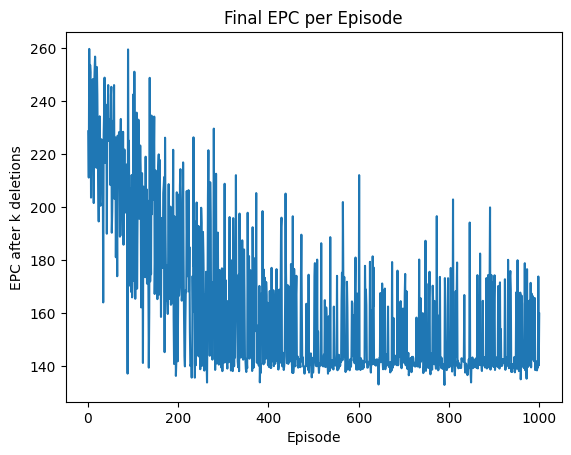

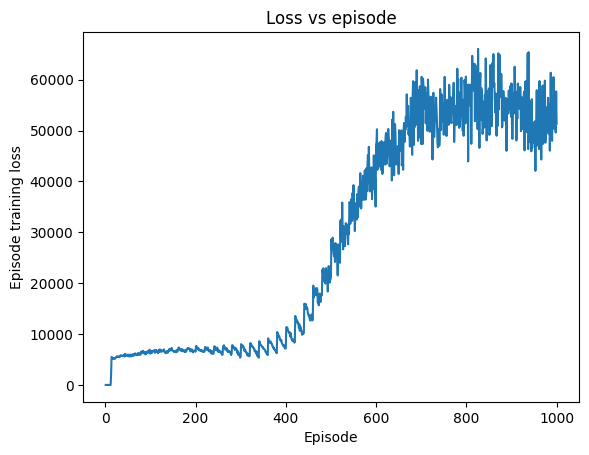

In [28]:
train_dqn()

In [5]:
"""
Self‑contained script to **train** and **deploy** a GCN‑DQN policy for the
Stochastic Critical‑Node Detection Problem (CNDP).

Quick start (train on N=30 → save model):
```bash
python cndp_dqn.py            # ~5–10 min CPU
```
Then prune k nodes on a bigger graph:
```python
import networkx as nx, cndp_dqn as cdqn
G = nx.erdos_renyi_graph(100, 0.15)
for u, v in G.edges(): G[u][v]['p'] = 0.5
print(cdqn.prune_k_nodes(G, k=10))
```
"""

# ================ imports & device ================
import random, math, time
from collections import deque

import networkx as nx, numpy as np, torch
import torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ================ EPC estimator ===================

def epc_mc(G: nx.Graph, M: int = 1500) -> float:
    V = list(G.nodes())
    if len(V) < 2: return 0.0
    tot = 0
    for _ in range(M):
        u = random.choice(V); seen = {u}; stack = [u]
        while stack:
            v = stack.pop()
            for w in G.neighbors(v):
                if w not in seen and random.random() < G.edges[v, w]['p']:
                    seen.add(w); stack.append(w)
        tot += len(seen) - 1
    n = len(V)
    return n * tot / (2*M)

# ================ graph generator ================

def gen_graph(N=30, p=0.2) -> nx.Graph:
    G = nx.erdos_renyi_graph(N, p)
    for u, v in G.edges(): G[u][v]['p'] = np.random.beta(2, 5)
    return G

# ================ RL environment ================
class CNDPEnv:
    def __init__(self, G: nx.Graph, k: int):
        self.G0, self.k = G, k
        self.nodes = list(G.nodes()); self.idx = {n:i for i,n in enumerate(self.nodes)}; self.N=len(self.nodes)
        self.reset()
    def _adj_norm(self):
        A = torch.zeros(self.N, self.N)
        for u, v in self.G.edges():
            i,j = self.idx[u], self.idx[v]; A[i,j]=A[j,i]=1
        A += torch.eye(self.N)
        d = A.sum(1)
        D = torch.diag(torch.pow(d+1e-7,-0.5))
        return D@A@D
    def _obs(self):
        return {'x': torch.ones(self.N,1), 'adj': self._adj_norm(),
                'mask': torch.tensor([n in self.left for n in self.nodes])}
    def reset(self):
        self.G=self.G0.copy(); self.left=set(self.nodes); self.steps=0
        self.prev=epc_mc(self.G); return self._obs()
    def step(self,a:int):
        n=self.nodes[a]; self.G.remove_node(n); self.left.remove(n)
        epc=epc_mc(self.G); r=self.prev-epc; self.prev=epc
        self.steps+=1; done=self.steps>=self.k
        return self._obs(), r, done, {'epc':epc}

# ================ Q‑network ======================
class GCN_Q(nn.Module):
    def __init__(self, h=64):
        super().__init__(); self.g1=nn.Linear(1,h); self.g2=nn.Linear(h,h); self.head=nn.Sequential(nn.Linear(h,32),nn.ReLU(),nn.Linear(32,1))
    def forward(self,x,adj,m):
        h=F.relu(self.g1(adj@x)); h=F.relu(self.g2(adj@h)); q=self.head(h).squeeze(-1)
        return q.masked_fill(~m,-1e9)

# ================ replay ==========================
class Replay:
    def __init__(self,cap=40000): self.buf=deque(maxlen=cap)
    def push(self,*tr): self.buf.append(tr)
    def sample(self,n): 
      S,A,R,S2,D=zip(*random.sample(self.buf,n))
      return list(S),torch.tensor(A),torch.tensor(R),list(S2),torch.tensor(D)
    def __len__(self): return len(self.buf)

# ================ training loop ==================
def train(epochs=250,N=30,k=5,p=0.2,batch=64,lr=1e-4,gamma=0.99,
          eps0=1.0,eps_end=0.05,eps_decay=0.995,sync=20,save='cndp_dqn.pt'):
    net,tgt=GCN_Q().to(DEVICE),GCN_Q().to(DEVICE); tgt.load_state_dict(net.state_dict())
    opt,mem=torch.optim.Adam(net.parameters(),lr),Replay(); eps=eps0; curve=[]
    for ep in range(1,epochs+1):
        env=CNDPEnv(gen_graph(N,p),k); s=env.reset(); ep_r=0
        done=False
        while not done:
            x,adj,m=s['x'].to(DEVICE),s['adj'].to(DEVICE),s['mask'].to(DEVICE)
            if random.random()<eps: a=random.choice(m.nonzero().flatten().tolist())
            else: a=net(x,adj,m).argmax().item()
            s2,r,done,info=env.step(a); mem.push(s,a,r,s2,done); s=s2; ep_r+=r
            if len(mem)>=batch:
                S,A,R,S2,D=mem.sample(batch); A,R,D=A.to(DEVICE),R.to(DEVICE),D.float().to(DEVICE)
                x1=torch.stack([s['x'] for s in S]).to(DEVICE)
                a1=torch.stack([s['adj'] for s in S]).to(DEVICE)
                m1=torch.stack([s['mask'] for s in S]).to(DEVICE)
                q=net(x1,a1,m1).gather(1,A.unsqueeze(1)).squeeze(1)
                x2=torch.stack([s['x'] for s in S2]).to(DEVICE)
                a2=torch.stack([s['adj'] for s in S2]).to(DEVICE)
                m2=torch.stack([s['mask'] for s in S2]).to(DEVICE)
                with torch.no_grad(): qn=tgt(x2,a2,m2).max(1)[0]
                y=R.to(DEVICE)+gamma*qn*(1-D)
                loss=F.mse_loss(q,y); opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(net.parameters(),0.5); opt.step()
        curve.append(info['epc']); eps=max(eps_end,eps*eps_decay)
        if ep%sync==0: 
            tgt.load_state_dict(net.state_dict())

        if ep%50==0: 
            print(f"Ep{ep:3d}/{epochs}  ΔR {ep_r:+6.1f}  EPC {info['epc']:.1f}  eps {eps:.2f}")


    torch.save(net.state_dict(),save); print('saved',save)
    plt.plot(curve); plt.xlabel('episode'); plt.ylabel('final EPC'); plt.show()

# ================ inference ======================
@torch.no_grad()
def prune_k_nodes(G: nx.Graph, k:int, model_path='cndp_dqn.pt'):
    f=GCN_Q().to(DEVICE); f.load_state_dict(torch.load(model_path, map_location=DEVICE)); f.eval()
    env=CNDPEnv(G.copy(),k); obs=env.reset(); removed=[]
    for _ in range(k):
        x,adj,m=obs['x'].to(DEVICE),obs['adj'].to(DEVICE),obs['mask'].to(DEVICE)
        a=f(x,adj,m).argmax().item(); removed.append(env.nodes[a])
        obs,_,_,_=env.step(a)
    return removed

Ep 50/250  ΔR +104.2  EPC 74.8  eps 0.78
Ep100/250  ΔR +173.4  EPC 75.4  eps 0.61
Ep150/250  ΔR +125.1  EPC 68.9  eps 0.47
Ep200/250  ΔR +167.0  EPC 68.5  eps 0.37
Ep250/250  ΔR +121.5  EPC 49.1  eps 0.29
saved cndp_dqn.pt


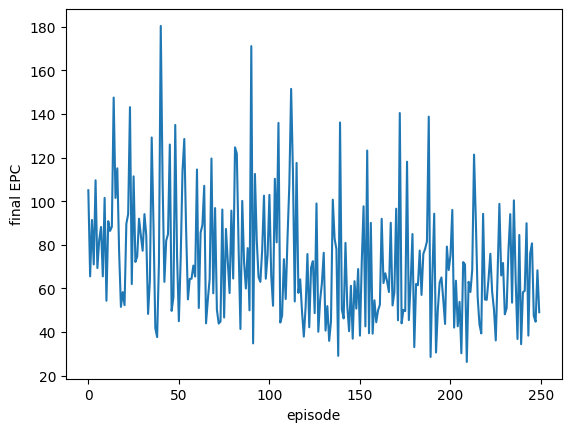

In [34]:
train()

In [49]:
"""
Dueling-GCN ▸ Double-DQN for Stochastic Critical-Node Detection
---------------------------------------------------------------
 • Fast EPC via Numba
 • Dueling head  (V + A)
 • Double-DQN target
 • Curriculum training over (N, k) stages
 • Greedy inference helper
"""

import random, math, time
from collections import deque
from typing import List, Dict, Tuple
from pathlib import Path

import numpy as np
import networkx as nx
import numba as nb
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------ #
#                        EPC  (CSR  +  Numba)                        #
# ------------------------------------------------------------------ #
def nx_to_csr(G: nx.Graph) -> Tuple[
        List[int], Dict[int,int], np.ndarray, np.ndarray, np.ndarray]:
    nodes = list(G.nodes())
    idx   = {u:i for i,u in enumerate(nodes)}
    indptr, indices, probs = [0], [], []
    for u in nodes:
        for v in G.neighbors(u):
            indices.append(idx[v])
            probs  .append(G.edges[u,v]['p'])
        indptr.append(len(indices))
    return (nodes, idx,
            np.asarray(indptr ,np.int32),
            np.asarray(indices,np.int32),
            np.asarray(probs  ,np.float32))

@nb.njit(inline="always")
def _bfs_size(start, indptr, indices, probs, deleted):
    n = deleted.size
    stack = np.empty(n, np.int32)
    seen  = np.zeros(n, np.uint8)
    top=0; stack[top]=start; top+=1; seen[start]=1; size=1
    while top:
        top-=1; v=stack[top]
        for ei in range(indptr[v], indptr[v+1]):
            w = indices[ei]
            if deleted[w] or seen[w] \
               or np.random.random() >= probs[ei]:
                continue
            seen[w]=1; stack[top]=w; top+=1; size+=1
    return size-1

@nb.njit(parallel=True)
def epc_mc(indptr,indices,probs,deleted,M):
    surv = np.where(deleted==0)[0]
    m = surv.size
    if m < 2: return 0.0
    acc = 0.0
    for _ in nb.prange(M):
        u = surv[np.random.randint(m)]
        acc += _bfs_size(u, indptr, indices, probs, deleted)
    return m*acc/(2*M)

# ------------------------------------------------------------------ #
#                               Env                                  #
# ------------------------------------------------------------------ #
class CNDPEnv:
    def __init__(self, G: nx.Graph, k: int, mc_samples=1500):
        nodes, idx, indptr, indices, probs = nx_to_csr(G)
        self.nodes, self.idx = nodes, idx
        self.indptr,self.indices,self.probs = indptr,indices,probs
        self.N,self.k,self.M = len(nodes),k,mc_samples
        self.deleted = np.zeros(self.N, np.uint8)
        self.reset()
    def _norm_adj(self):
        A = torch.zeros(self.N, self.N)
        for i in range(self.N):
            if self.deleted[i]: continue
            for ei in range(self.indptr[i], self.indptr[i+1]):
                j = self.indices[ei]
                if self.deleted[j]: continue
                A[i,j]=A[j,i]=1
        A += torch.eye(self.N)
        d = A.sum(1)
        D = torch.diag(torch.pow(d+1e-7,-0.5))
        return D@A@D
    def _obs(self):
        return {"x":torch.ones(self.N,1),
                "adj":self._norm_adj(),
                "mask":torch.tensor(self.deleted==0)}
    def reset(self):
        self.deleted[:] = 0; self.steps=0
        self.prev   = epc_mc(self.indptr,self.indices,self.probs,
                             self.deleted,self.M)
        self.epc0   = self.prev           # for reward normalisation
        return self._obs()
    def step(self,a:int):
        if self.deleted[a]: raise ValueError("removed")
        self.deleted[a]=1
        epc = epc_mc(self.indptr,self.indices,self.probs,
                     self.deleted,self.M)
        reward = (self.prev - epc) / self.epc0   # relative drop
        self.prev = epc; self.steps += 1
        done = self.steps >= self.k
        return self._obs(), reward, done, {"epc": epc}

# ------------------------------------------------------------------ #
#                       Graph generator                              #
# ------------------------------------------------------------------ #
def gen_graph(N=30, p=0.2, p_edge=1.0):
    G = nx.erdos_renyi_graph(N,p)
    for u,v in G.edges():
        G[u][v]['p'] = p_edge
    return G

# ------------------------------------------------------------------ #
#                   Dueling-GCN Q-network                            #
# ------------------------------------------------------------------ #
class DuelingGCN_Q(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.g1, self.g2 = nn.Linear(1,h), nn.Linear(h,h)
        self.val = nn.Sequential(nn.Linear(h,32), nn.ReLU(), nn.Linear(32,1))
        self.adv = nn.Sequential(nn.Linear(h,32), nn.ReLU(), nn.Linear(32,1))
    def forward(self,x,adj,mask):
        h = torch.relu(self.g1(adj@x))
        h = torch.relu(self.g2(h))
        V = self.val(h).squeeze(-1)
        A = self.adv(h).squeeze(-1)
        A_mean = (A*mask.float()).sum() / mask.float().sum().clamp_min(1)
        Q = V + (A - A_mean)
        return Q.masked_fill(~mask, -1e9)

class Replay:
    def __init__(self, cap=40_000): self.buf=deque(maxlen=cap)
    def push(self,*tr): self.buf.append(tr)
    def sample(self,n):
        S,A,R,S2,D = zip(*random.sample(self.buf,n))
        return list(S),torch.tensor(A),torch.tensor(R),list(S2),torch.tensor(D)
    def __len__(self): return len(self.buf)

# ------------------------------------------------------------------ #
#               Curriculum  training routine                         #
# ------------------------------------------------------------------ #
def curriculum_train(
        p_edges: list[float],                # list of edge reliabilities
        stages: list[tuple[int,int,int]],    # [(N,k,episodes), ...]
        *,
        p: float = 0.0443,
        **hparams):

    net, tgt = DuelingGCN_Q().to(DEVICE), DuelingGCN_Q().to(DEVICE)
    tgt.load_state_dict(net.state_dict())
    opt, buf = torch.optim.Adam(net.parameters(), hparams.get("lr", 1e-4)), Replay()

    # hyper-params
    batch   = hparams.get("batch", 64)
    gamma   = hparams.get("gamma", 0.99)
    sync    = hparams.get("sync", 10)
    eps, eps_min, eps_decay = (
        hparams.get("eps0", 1.0),
        hparams.get("eps_min", 0.05),
        hparams.get("eps_decay", 0.995),
    )

    epc_curve, loss_curve = [], []

    for rho in p_edges:                                   
        print(f"\n### Curriculum block  p_edge={rho:.1f} ###")
        for (N, k, ep_count) in stages:                    # inner loop
            print(f"-- stage  N={N}  k={k}  episodes={ep_count} --")
            buf = Replay()       # ← clear buffer for this (N,k)
            for ep in range(1, ep_count + 1):

                env = CNDPEnv(gen_graph(N, p, rho), k, mc_samples=5000)
                s = env.reset()
                done = False

                ep_r = 0.0
                ep_min_epc = float("inf")   # NEW
                ep_loss_sum = 0.0
                upd_steps   = 0

                while not done:
                    x, adj, m = (
                        s["x"].to(DEVICE),
                        s["adj"].to(DEVICE),
                        s["mask"].to(DEVICE),
                    )
                    a = (
                        random.choice(m.nonzero(as_tuple=False).flatten().tolist())
                        if random.random() < eps
                        else net(x, adj, m).argmax().item()
                    )
                    s2, r, done, info = env.step(a)
                    ep_min_epc = min(ep_min_epc, info["epc"])  # NEW
                    buf.push(s, a, r, s2, done)
                    s = s2
                    ep_r += r

                    # --------- TD update ---------
                    if len(buf) >= batch:
                        S, A, R, S2, D = buf.sample(batch)
                        A, R, D = (
                            A.to(DEVICE),
                            R.to(DEVICE),
                            D.float().to(DEVICE),
                        )

                        x1 = torch.stack([t["x"] for t in S]).to(DEVICE)
                        adj1 = torch.stack([t["adj"] for t in S]).to(DEVICE)
                        m1 = torch.stack([t["mask"] for t in S]).to(DEVICE)
                        q_sa = net(x1, adj1, m1).gather(1, A.unsqueeze(1)).squeeze(1)

                        x2 = torch.stack([t["x"] for t in S2]).to(DEVICE)
                        adj2 = torch.stack([t["adj"] for t in S2]).to(DEVICE)
                        m2 = torch.stack([t["mask"] for t in S2]).to(DEVICE)
                        with torch.no_grad():
                            a_next = net(x2, adj2, m2).argmax(1)
                            qn = tgt(x2, adj2, m2)[torch.arange(batch), a_next]

                        y = R.to(DEVICE) + gamma * qn * (1 - D)
                        loss = F.mse_loss(q_sa, y)

                        opt.zero_grad()
                        loss.backward()
                        nn.utils.clip_grad_norm_(net.parameters(), 0.05)
                        opt.step()

                        ep_loss_sum += loss.item()
                        upd_steps += 1

                # ---- episode bookkeeping ----
                epc_curve.append(info["epc"])                      # final EPC
                loss_curve.append(ep_loss_sum / max(1, upd_steps)) # mean loss
                eps = max(eps_min, eps * eps_decay)

                if ep % sync == 0:
                    tgt.load_state_dict(net.state_dict())

                if ep % 100 == 0:
                    mean_loss = loss_curve[-1]
                    print(
                        f"   ep {ep:3d}/{ep_count}  ΔR {ep_r:+7.2f}  "
                        f"FinalEPC {info['epc']:.1f}  "
                        f"MinEPC {ep_min_epc:.1f}  "
                        f"mean-loss {mean_loss:.3f}"
                    )

    torch.save(net.state_dict(), "dqn_pedge_curric.pt")
    print("saved dqn_pedge_curric.pt")

    # ---------- twin-axis plot ----------
    fig, ax1 = plt.subplots()
    ax1.plot(epc_curve, color="tab:blue", alpha=0.7)
    ax1.set_xlabel("episode")
    ax1.set_ylabel("final EPC", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.plot(loss_curve, color="tab:red", alpha=0.4)
    ax2.set_ylabel("mean TD loss", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    plt.title("Curriculum over edge reliability")
    fig.tight_layout()
    plt.show()

# ------------------------------------------------------------------ #
#                          Inference                                 #
# ------------------------------------------------------------------ #
@torch.no_grad()
def prune_k_nodes(G: nx.Graph, k:int, model_path="dqn_curriculum.pt"):
    pol = DuelingGCN_Q().to(DEVICE)
    pol.load_state_dict(torch.load(model_path, map_location=DEVICE)); pol.eval()
    env = CNDPEnv(G.copy(), k, mc_samples=500)  # mc samples irrelevant
    s = env.reset(); rem=[]
    for _ in range(k):
        x,adj,m = s['x'].to(DEVICE), s['adj'].to(DEVICE), s['mask'].to(DEVICE)
        a = pol(x,adj,m).argmax().item()
        rem.append(env.nodes[a])
        s,_,_,_ = env.step(a)
    return rem




### Curriculum block  p_edge=1.0 ###
-- stage  N=20  k=3  episodes=500 --
   ep 100/500  ΔR   +0.55  FinalEPC 3.0  MinEPC 3.0  mean-loss 0.125
   ep 200/500  ΔR   +0.89  FinalEPC 2.0  MinEPC 2.0  mean-loss 0.214
   ep 300/500  ΔR   +0.90  FinalEPC 2.9  MinEPC 2.9  mean-loss 0.267
   ep 400/500  ΔR   +0.49  FinalEPC 3.1  MinEPC 3.0  mean-loss 0.275
   ep 500/500  ΔR   +0.51  FinalEPC 11.1  MinEPC 11.1  mean-loss 0.236
-- stage  N=50  k=5  episodes=1000 --
   ep 100/1000  ΔR   +0.86  FinalEPC 101.0  MinEPC 101.0  mean-loss 0.069
   ep 200/1000  ΔR   +0.67  FinalEPC 323.9  MinEPC 323.9  mean-loss 0.059
   ep 300/1000  ΔR   +0.84  FinalEPC 152.6  MinEPC 152.6  mean-loss 0.049
   ep 400/1000  ΔR   +0.49  FinalEPC 356.1  MinEPC 356.1  mean-loss 0.057
   ep 500/1000  ΔR   +0.83  FinalEPC 111.0  MinEPC 111.0  mean-loss 0.049
   ep 600/1000  ΔR   +0.66  FinalEPC 206.7  MinEPC 206.7  mean-loss 0.053
   ep 700/1000  ΔR   +0.65  FinalEPC 77.5  MinEPC 77.5  mean-loss 0.049
   ep 800/1000  ΔR   +0.

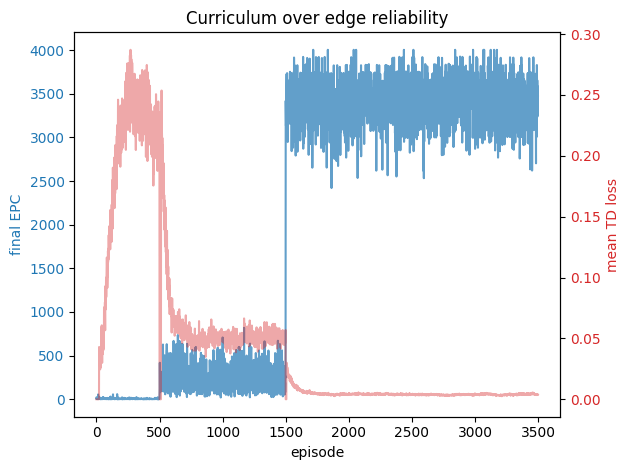

In [50]:
stages = [
  (20,  3,   500),
  (50,  5,  1000),
  (100, 10, 2000),
]
curriculum_train(
  p_edges=[1.0],
  stages=stages,
  p=0.04,
  lr=1e-4,
  batch=64,
  gamma=0.99,
  eps0=1.0,
  eps_min=0.05,
  eps_decay=0.995,
  sync=10
)


In [62]:
for N, k in [(20,3),(50,5),(100,10)]:
    G = gen_graph(N, p=0.0443, p_edge=1.0)
    nodes_to_remove = prune_k_nodes(G, k, model_path="dqn_pedge_curric.pt")
    epc = component_sampling_epc_mc(G, set(nodes_to_remove), 100_000)
    print(f"N={N}, k={k} → remove nodes:", nodes_to_remove)
    print(f"EPC: {epc}")

N=20, k=3 → remove nodes: [18, 0, 3]
EPC: 1.005125
N=50, k=5 → remove nodes: [9, 42, 41, 10, 13]
EPC: 111.15
N=100, k=10 → remove nodes: [3, 52, 64, 13, 14, 72, 38, 29, 84, 5]
EPC: 3241.008


In [62]:
@torch.no_grad()
def prune_k_nodes(G: nx.Graph, k: int, model_path: str = 'cndp_dqn.pt') -> List[int]:
    """Greedy inference: return the *k* nodes the trained policy removes."""
    model = GCN_Q().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    env = CNDPEnv(G.copy(), k)
    obs = env.reset()
    removed = []
    for _ in range(k):
        x = obs['x'].to(DEVICE)
        adj = obs['adj'].to(DEVICE)
        mask = obs['mask'].to(DEVICE)
        a = model(x, adj, mask).argmax().item()
        removed.append(env.nodes[a])
        obs, _, _, _ = env.step(a)
    return removed

In [61]:
Gtest = nx.erdos_renyi_graph(100, 0.0443)

for u, v in Gtest.edges():
  Gtest[u][v]['p'] = 1.0

G0     = Gtest.copy()
EPC0   = component_sampling_epc_mc(G0, set(), 20_000)    # before deletions
nodes  = prune_k_nodes(Gtest, 10, "cndp_dqn.pt")
EPC10  = component_sampling_epc_mc(Gtest, set(nodes), 20_000)

print(f"initial EPC  : {EPC0:.0f}")
print(f"after policy : {EPC10:.0f}")
print(f"reduction %  : {(EPC0-EPC10)/EPC0*100:.1f}%")

RuntimeError: Error(s) in loading state_dict for DuelingGCN_Q:
	Missing key(s) in state_dict: "g1.weight", "g1.bias", "g2.weight", "g2.bias", "val.0.weight", "val.0.bias", "val.2.weight", "val.2.bias", "adv.0.weight", "adv.0.bias", "adv.2.weight", "adv.2.bias". 
	Unexpected key(s) in state_dict: "l1.weight", "l1.bias", "l2.weight", "l2.bias", "head.0.weight", "head.0.bias", "head.2.weight", "head.2.bias". 

In [79]:
NODES = 50
SEED = 42
er = nx.erdos_renyi_graph(NODES, 0.5025, seed=SEED)
print(er)
print(nx.barabasi_albert_graph(NODES, 25,seed=SEED))
print(nx.watts_strogatz_graph(NODES, 25, 0.3, seed=SEED))

Graph with 50 nodes and 600 edges
Graph with 50 nodes and 625 edges
Graph with 50 nodes and 600 edges


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import numpy as np
from collections import deque
import random
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from numba import njit, prange
from typing import Tuple, List, Dict

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. User-Provided High-Performance EPC Functions ---

def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr 'p') to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     # Ensure sorted iteration for reproducibility if needed, though not strictly required
     for u in sorted(nodes):
         # Iterate over neighbors in a sorted order
         for v in sorted(list(G.neighbors(u))):
             # Ensure we only add edges once for undirected graph
             if u < v:
                 indices.append(idx_of[v])
                 indices.append(idx_of[u])
                 p = G.edges[u, v]['p']
                 probs.append(p)
                 probs.append(p)

     # This part needs correction for a proper CSR representation from NetworkX
     # Let's rebuild it to be correct and efficient.
     nodes = list(G.nodes())
     idx_of = {node: i for i, node in enumerate(nodes)}
     
     adj = nx.to_scipy_sparse_array(G, nodelist=nodes, weight='p', format='csr')
     
     return (
         nodes,
         idx_of,
         adj.indptr,
         adj.indices,
         adj.data.astype(np.float32) # Probabilities are the data
     )


@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    # Ensure start node is valid
    if start >= n or deleted[start]:
        return 0

    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:  # edge absent
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1

@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        # Correctly sample from the list of surviving nodes
        u_idx = np.random.randint(m)
        u = surv[u_idx]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)
        
    # The EPC is the expected number of connected pairs.
    # The sum of (size_of_component - 1) over all nodes is 2 * num_pairs.
    # So, E[sum(|C_u|-1)] = E[sum_i |C_i|(|C_i|-1)] = 2 * E[num_pairs]
    # The estimator for E[sum(|C_u|-1)] is m * (acc / num_samples)
    return (m * acc) / (2.0 * num_samples)


# --- 2. GCN + Dueling DQN Model (Unchanged) ---
class GcnDuelingDqn(nn.Module):
    def __init__(self, num_nodes, feature_size=64, gcn_hidden_size=128, fc_hidden_size=64):
        super(GcnDuelingDqn, self).__init__()
        self.conv1 = GCNConv(feature_size, gcn_hidden_size)
        self.conv2 = GCNConv(gcn_hidden_size, gcn_hidden_size)
        self.value_stream = nn.Sequential(
            nn.Linear(gcn_hidden_size, fc_hidden_size), nn.ReLU(), nn.Linear(fc_hidden_size, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(gcn_hidden_size, fc_hidden_size), nn.ReLU(), nn.Linear(fc_hidden_size, 1)
        )

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=0))
        return q_values.squeeze(-1)

# --- 3. Replay Buffer (Unchanged) ---
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences])).float().to(DEVICE)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences])).long().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences])).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences]).astype(np.uint8)).float().to(DEVICE)
        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.memory)

# --- 4. The Agent (Unchanged logic, but will interact with new reward) ---
class DuelingDoubleDQNAgent:
    def __init__(self, num_nodes, k_nodes, buffer_size=10000, batch_size=64,
                 gamma=0.99, lr=5e-4, tau=1e-3):
        self.num_nodes = num_nodes
        self.k = k_nodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.feature_size = self.num_nodes + 1
        self.policy_net = GcnDuelingDqn(num_nodes, feature_size=self.feature_size).to(DEVICE)
        self.target_net = GcnDuelingDqn(num_nodes, feature_size=self.feature_size).to(DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size, batch_size)

    def create_features(self, selected_mask):
        identities = np.eye(self.num_nodes)
        selection_feature = selected_mask.reshape(-1, 1)
        features = np.hstack([identities, selection_feature])
        return torch.tensor(features, dtype=torch.float).to(DEVICE)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def select_action(self, state_mask, edge_index, edge_weight, epsilon=0.0):
        available_actions = np.where(state_mask == 0)[0]
        if not available_actions.any(): return None
        if random.random() > epsilon:
            self.policy_net.eval()
            with torch.no_grad():
                node_features = self.create_features(state_mask)
                q_values = self.policy_net(node_features, edge_index, edge_weight)
                q_values[state_mask.astype(bool)] = -float('inf')
                action = np.argmax(q_values.cpu().numpy())
            self.policy_net.train()
        else:
            action = random.choice(available_actions)
        return action

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # This part requires global access to edge_index and edge_weight
        # which is handled by passing them from the main script context.
        q_targets_next_list = []
        for next_state_mask in next_states:
            with torch.no_grad():
                next_node_features = self.create_features(next_state_mask.cpu().numpy())
                q_policy_next = self.policy_net(next_node_features, edge_index, edge_weight)
                q_policy_next[next_state_mask.bool()] = -float('inf')
                best_action_next = q_policy_next.argmax().unsqueeze(0)
                q_target_next_val = self.target_net(next_node_features, edge_index, edge_weight)[best_action_next]
                q_targets_next_list.append(q_target_next_val)
        q_targets_next = torch.cat(q_targets_next_list).unsqueeze(1)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))
        q_expected_list = []
        for i, state_mask in enumerate(states):
             node_features = self.create_features(state_mask.cpu().numpy())
             q_expected_val = self.policy_net(node_features, edge_index, edge_weight)[actions[i]]
             q_expected_list.append(q_expected_val)
        q_expected = torch.cat(q_expected_list).unsqueeze(1)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.policy_net, self.target_net)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

# --- 5. Main Training Loop (Corrected) ---
if __name__ == '__main__':
    # --- Parameters ---
    NUM_NODES = 20
    P_BACKBONE = 0.3
    P_EDGE_INSTANCE = 0.5
    K_NODES_TO_REMOVE = 3
    # More samples are better but slower. Numba makes this very fast.
    MONTE_CARLO_SAMPLES = 1000

    NUM_EPISODES = 600
    EPSILON_START = 1.0
    EPSILON_END = 0.01
    EPSILON_DECAY = 0.995
    BATCH_SIZE = 64
    
    # --- Setup ---
    G = nx.erdos_renyi_graph(NUM_NODES, P_BACKBONE)
    
    # *** FIX: Set BOTH 'p' and 'weight' attributes ***
    # 'p' is for your epc_mc function via nx_to_csr.
    # 'weight' is the standard for PyTorch Geometric's GCN layers.
    for u, v in G.edges():
        G.edges[u, v]['p'] = P_EDGE_INSTANCE
        G.edges[u, v]['weight'] = P_EDGE_INSTANCE # Add this line
    
    if not nx.is_connected(G):
        lcc_nodes = max(nx.connected_components(G), key=len)
        G = G.subgraph(lcc_nodes).copy()
        G = nx.convert_node_labels_to_integers(G)
        NUM_NODES = G.number_of_nodes()
        print(f"Using LCC with {NUM_NODES} nodes.")

    # 1. Convert to CSR for your fast EPC function (uses 'p')
    print("Converting graph to CSR format for EPC calculation...")
    csr_nodes, csr_idx_of, csr_indptr, csr_indices, csr_probs = nx_to_csr(G)

    # 2. Convert to PyG format for the GCN
    print("Converting graph to PyTorch Geometric format for GCN...")
    
    # *** FIX: Remove group_edge_attrs. from_networkx will auto-detect 'weight'. ***
    data = from_networkx(G) 
    edge_index = data.edge_index.to(DEVICE)
    
    # *** FIX: Access data.edge_weight instead of data.p ***
    edge_weight = data.edge_weight.to(DEVICE)

    # The rest of the script remains the same
    agent = DuelingDoubleDQNAgent(num_nodes=NUM_NODES, k_nodes=K_NODES_TO_REMOVE, batch_size=BATCH_SIZE)
    
    print("\nStarting Training with high-performance EPC reward...")
    scores = []
    epsilon = EPSILON_START
    
    initial_deleted_mask = np.zeros(NUM_NODES, dtype=bool)
    initial_epc = epc_mc(csr_indptr, csr_indices, csr_probs, initial_deleted_mask, MONTE_CARLO_SAMPLES * 5)

    for i_episode in range(1, NUM_EPISODES + 1):
        selected_nodes_mask = np.zeros(NUM_NODES)
        episode_reward = 0
        
        for step in range(K_NODES_TO_REMOVE):
            state = selected_nodes_mask.copy()
            deleted_mask_before = state.astype(bool)
            
            action = agent.select_action(state, edge_index, edge_weight, epsilon)
            if action is None: break
            
            epc_before = epc_mc(csr_indptr, csr_indices, csr_probs, deleted_mask_before, MONTE_CARLO_SAMPLES)
            
            deleted_mask_after = deleted_mask_before.copy()
            deleted_mask_after[action] = True
            
            epc_after = epc_mc(csr_indptr, csr_indices, csr_probs, deleted_mask_after, MONTE_CARLO_SAMPLES)
            
            reward = epc_before - epc_after
            episode_reward += reward

            next_state = state.copy()
            next_state[action] = 1
            done = (step == K_NODES_TO_REMOVE - 1)
            
            agent.step(state, action, reward, next_state, done)
            selected_nodes_mask = next_state
            
            if done: break
        
        scores.append(episode_reward)
        epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)
        
        if i_episode % 20 == 0:
            print(f"Episode {i_episode}\tAvg Score (EPC reduction): {np.mean(scores[-20:]) :.2f}\tEpsilon: {epsilon:.2f}")

    print("\n--- Evaluation ---")
    selected_nodes_mask = np.zeros(NUM_NODES)
    print(f"Goal: Select {K_NODES_TO_REMOVE} nodes to maximize EPC disruption.")
    print(f"Initial Expected Pairwise Connectivity (EPC): {initial_epc:.2f}")

    for step in range(K_NODES_TO_REMOVE):
        action = agent.select_action(selected_nodes_mask, edge_index, edge_weight, epsilon=0)
        selected_nodes_mask[action] = 1
        print(f"Step {step+1}: Agent selects node {action}")
        
    final_deleted_mask = selected_nodes_mask.astype(bool)
    final_epc = epc_mc(csr_indptr, csr_indices, csr_probs, final_deleted_mask, MONTE_CARLO_SAMPLES * 5)
    
    print(f"\nFinal selected nodes: {np.where(final_deleted_mask)[0]}")
    print(f"Final EPC: {final_epc:.2f}")
    print(f"Total Disruption (EPC Reduction): {(initial_epc - final_epc):.2f}")

Converting graph to CSR format for EPC calculation...
Converting graph to PyTorch Geometric format for GCN...


AttributeError: 'NoneType' object has no attribute 'to'